In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Csanad\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data aquisition&preparation

In [2]:
# Oxford-IIIT pet dataset: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
dataset_name = "oxford_iiit_pet" # dataset name
split = [
    "train[:60%]+test[:60%]",
    "train[60%:80%]+test[60%:80%]",
    "train[80%:]+test[80%:]"
] # train-validation-test split

In [3]:
# Oxford Flowers 102 dataset: https://www.tensorflow.org/datasets/catalog/oxford_flowers102
dataset_name = "oxford_flowers102" # dataset name
split = [
    "train[:60%]+validation[:60%]+test[:60%]",
    "train[60%:80%]+validation[60%:80%]+test[60%:80%]",
    "train[80%:]+validation[80%:]+test[80%:]"
] # train-validation-test split

In [4]:
# Hyperparameters
img_size = 64 # resized image size
batch_size = 64 # batch size
timesteps = 500 # number of timesteps (noise levels)

latent_dim = 64 # latent dimension
learning_rate = 1e-3 # learning rate
num_epochs = 1 # number of epochs (TODO change to a larger number)

In [5]:
def preprocess_image(data): # preprocess an image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width) # find the smallest dimension
    img = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    ) # crop the image to a square
    img = tf.cast(img, dtype=tf.float32) # cast the image to float32
    img = tf.image.resize(img, size=(img_size, img_size), antialias=True) # resize the image to img_size x img_size
    return tf.clip_by_value(img * 2.0 / 255.0, -1.0, 1.0) # normalize the image to [-1, 1]

def reverse_transform(img):
    return tf.clip_by_value((img + 1.0) / 2.0 * 255.0, 0.0, 255.0).numpy().astype(np.uint8) # reverse the normalization

In [6]:
def preprocess_dataset(dataset): # preprocess a dataset
    return (dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # preprocess images of the dataset
            .batch(batch_size, drop_remainder=True) # organize the dataset into batches
            .shuffle(2 * batch_size) # shuffle the dataset
            .prefetch(buffer_size=tf.data.AUTOTUNE)) # prefetch data for better performance

def load_data(dataset_name): # load dataset from tensorflow datasets with the given name
    train_ds, val_ds, test_ds = tfds.load(dataset_name, split=split, shuffle_files=True) # load the dataset
    train_ds = preprocess_dataset(train_ds) # preprocess the training dataset
    val_ds = preprocess_dataset(val_ds) # preprocess the validation dataset
    test_ds = preprocess_dataset(test_ds) # preprocess the test dataset
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = load_data(dataset_name)

In [8]:
demo_img = next(iter(train_ds.unbatch().take(1)))

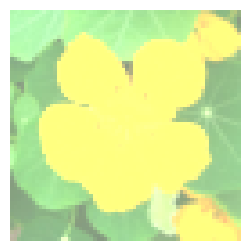

In [9]:
def show(img):
    plt.figure(figsize=(3, 3))
    plt.imshow(reverse_transform(img))
    plt.axis("off")
    plt.show()
    
def plot(imgs):
    _, axs = plt.subplots(figsize=(len(imgs)*2,2), ncols=len(imgs), nrows=1)
    for idx, img in enumerate(imgs):
        axs[idx].imshow(reverse_transform(img))
        axs[idx].axis("off")
    plt.tight_layout()

show(demo_img)

## Forward Diffusion Process 

In [45]:
class Diffusion:
    def __init__(self, timesteps=1000, min_beta=0.0001, max_beta = 0.02):
        self.timesteps = timesteps # number of timesteps (noise levels)
        self.min_beta = min_beta # first beta
        self.max_beta = max_beta # last beta
        
        self.betas = tf.linspace(min_beta, max_beta, timesteps) # setting schedule for beta (linear schedule)
        self.alphas = 1 - self.betas # alpha_t = 1 - beta_t
        self.alphas_cum_prod = tf.math.cumprod(self.alphas) # cumulative product of alphas
        self.alphas_cum_prod_prev = tf.concat([[1.0], self.alphas_cum_prod[:-1]], axis=0) # cumulative product of alphas shifted
        self.recip_sqrt_alphas = tf.math.square(1.0 / self.alphas) # reciprocals of squares of alphas
        self.sqrt_alphas_prod = tf.math.square(self.alphas_cum_prod) # squares of cumulative product of alphas
        self.sqrt_one_minus_alphas_prod = tf.math.square(1.0 - self.alphas_cum_prod) # squares of 1 - cumulative product of alphas
        
        # posterior variance (Equation 6, 7)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cum_prod_prev) / (1.0 - self.alphas_cum_prod)
        
    def extract(self, series, t, x_shape):
        out = tf.gather(series, t)
        return tf.reshape(out, [x_shape[0], 1, 1, 1])
    
    def q_sample(self, x_start, t, noise=None):
        x_start_shape = tf.shape(x_start)
        if noise is None:
            noise = tf.random.normal(x_start_shape, dtype=x_start.dtype)
        
        sqrt_alphas_prod_t = self.extract(self.sqrt_alphas_prod, t, x_start_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_start_shape)
        return sqrt_alphas_prod_t * x_start + sqrt_one_minus_alphas_prod_t * noise # Equation 12
    
    def p_sample_step(self, model, x, t, t_index):
        x_shape = tf.shape(x)
        beta_t = self.extract(self.betas, t, x_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_shape)
        recip_sqrt_alphas_t = self.extract(self.recip_sqrt_alphas, t, x_shape)
        noise_pred = model.predict([x, t])
        #print(noise_pred)
        model_mean = recip_sqrt_alphas_t * (x - noise_pred * beta_t / sqrt_one_minus_alphas_prod_t) # Equation 11
        
        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = self.extract(self.posterior_variance, t, x_shape)
            noise = tf.random.normal(x_shape, dtype=x.dtype) # sample noise from N(0, I)
            return model_mean + tf.math.square(posterior_variance_t) * noise # Algorith 2, Line 4
        
    def p_sample_full(self, model, shape, img=None, timesteps=None):
        if timesteps is None:
            timesteps = self.timesteps
        if img is None:
            img = tf.random.normal(shape, dtype=tf.float32) # pure noise initially
        imgs = [img]
        for t in reversed(range(timesteps)):
            t_batch = tf.fill((shape[0],), t)
            img = self.p_sample_step(model, img, t_batch, t)
            imgs.append(img)
        return imgs
    
    def generate_image(self, model, image_size=img_size):
        return self.p_sample_full(model, (1, image_size, image_size, 3))

In [46]:
forward_diffusion = Diffusion(timesteps)

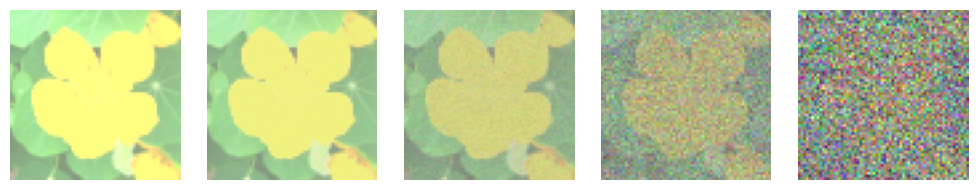

In [12]:
noisy_images = [tf.squeeze(forward_diffusion.q_sample(tf.expand_dims(demo_img, 0), tf.constant([t]))) for t in [0, 50, 100, 150, 200]]
plot(noisy_images)

## Neural network

A basic autoencoder for milestone 2

In [80]:
FILTERS = 16
DEPTH = 4

def create_u_net(depth: int) -> tf.keras.Model:
    img_input = tf.keras.layers.Input(
        name="img_input",
        shape=(img_size, img_size, 3),
    )
    time_input = tf.keras.layers.Input(
        name="time_input",
        shape=(1,1,1),
    )
    time2D = tf.keras.layers.UpSampling2D(size=(img_size, img_size), name="time_input_upscale")(time_input)
    combined = tf.keras.layers.Add()([img_input, time2D])
    
    conv1 = tf.keras.layers.Conv2D(
        FILTERS,
        (3, 3),
        activation=tf.keras.activations.relu,
        padding="same",
    )(combined)
    conv2 = tf.keras.layers.Conv2D(
        FILTERS,
        (3, 3),
        activation=tf.keras.activations.relu,
        padding="same",
    )(conv1)

    encoder_list = [conv2]

    for i in range(1, depth + 1):
        max_pooling = tf.keras.layers.MaxPooling2D((2, 2))(encoder_list[i - 1])
        conv3 = tf.keras.layers.Conv2D(
            FILTERS * 2**i,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        )(max_pooling)
        conv4 = tf.keras.layers.Conv2D(
            FILTERS * 2**i,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        )(conv3)
        encoder_list.append(conv4)

    decoder_list = [encoder_list[depth]]

    for i in reversed(range(depth)):
        up_sampling = tf.keras.layers.UpSampling2D((2, 2))(
            decoder_list[depth - (i + 1)]
        )
        # I don't know how to crop so I use Conv2D to halve the number of channels
        crop = tf.keras.layers.Conv2D(
            FILTERS * 2**i,
            (1, 1),
        )(up_sampling)
        added = tf.keras.layers.Add()([crop, encoder_list[i]])
        conv5 = tf.keras.layers.Conv2D(
            FILTERS * 2**i,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        )(added)
        conv6 = tf.keras.layers.Conv2D(
            FILTERS * 2**i,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        )(conv5)
        decoder_list.append(conv6)

    output_layer = tf.keras.layers.Conv2D(
        3,
        (1, 1),
        activation=tf.keras.activations.sigmoid,
    )(decoder_list[depth])

    u_net = tf.keras.models.Model([img_input, time_input], output_layer)
    u_net.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanSquaredError(),
    )

    return u_net


network = create_u_net(DEPTH)

In [13]:
def build_network(input_shape=(img_size, img_size, 3), latent_dim=64):
    image_input = tf.keras.layers.Input(shape=input_shape)
    time_input = tf.keras.layers.Input(shape=(1,))
    x = tf.keras.layers.Flatten()(image_input)
    combined = tf.keras.layers.Concatenate()([x, time_input])
    
    x = tf.keras.layers.Dense(latent_dim, activation="relu")(combined) # encoder
    x = tf.keras.layers.Dense(np.prod(input_shape), activation="linear")(x) # decoder
    x = tf.keras.layers.Reshape(input_shape)(x)
    
    return tf.keras.Model(inputs=[image_input, time_input], outputs=x, name="basic_autoencoder")

In [ ]:
class DiffusionModel(tf.keras.Model):
    def __init__(self, diffusion, net):
        super().__init__()
        self.diffusion = diffusion
        self.network = net
        
    def call(self, Xs, training=None, mask=None):
        return self.network(Xs)
    
    def random_t(self, Xs):
        return tf.random.uniform((tf.shape(Xs)[0],), minval=0, maxval=self.diffusion.timesteps, dtype=tf.int32)
    
    def step(self, Xs, t):
        noise = tf.random.normal(tf.shape(Xs), dtype=Xs.dtype)
        Xs_noisy = self.diffusion.q_sample(Xs, t, noise)
        noise_pred = self.network([Xs_noisy, t], training=True)
        return self.loss(noise, noise_pred)
        
    def train_step(self, Xs):
        t = self.random_t(Xs)
        with tf.GradientTape() as tape:
            loss = self.step(Xs, t)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}

    def test_step(self, Xs):
        t = self.random_t(Xs)
        return {"loss": self.step(Xs, t)}

network = build_network(input_shape=(img_size, img_size, 3), latent_dim=latent_dim)

In [81]:
model = DiffusionModel(diffusion=forward_diffusion, net=network)

In [82]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [83]:
model.fit(train_ds, epochs=num_epochs, batch_size=batch_size, validation_data=val_ds)

ValueError: in user code:

    File "C:\Users\Csanad\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Csanad\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Csanad\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Csanad\AppData\Local\Temp\ipykernel_10132\1133385398.py", line 22, in train_step
        loss = self.step(Xs, t)
    File "C:\Users\Csanad\AppData\Local\Temp\ipykernel_10132\1133385398.py", line 16, in step
        noise_pred = self.network([Xs_noisy, t], training=True)
    File "C:\Users\Csanad\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Csanad\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_9' (type Functional).
    
    Input 0 of layer "time_input_upscale" is incompatible with the layer: expected ndim=4, found ndim=1. Full shape received: (64,)
    
    Call arguments received by layer 'model_9' (type Functional):
      • inputs=['tf.Tensor(shape=(64, 64, 64, 3), dtype=float32)', 'tf.Tensor(shape=(64,), dtype=int32)']
      • training=True
      • mask=None


# Evaluation

TODO: evaluate the model on the test set

In [58]:
NUMBER_OF_IMAGES = 1
ROWS = 3
T = 1

original_images = next(iter(test_ds.unbatch().batch(NUMBER_OF_IMAGES)))
noisy_images = [forward_diffusion.q_sample(tf.expand_dims(img, 0), tf.constant([T])) for img in original_images]
reconstructed_images = [forward_diffusion.p_sample_full(model, (1, img_size, img_size, 3), img, T)[-1] for img in noisy_images]

1/1 [==============================] - 0s 78ms/step
[[[[-3.3945949e-03 -2.6166486e-04 -1.9435954e-03]
   [ 4.2049005e-03  1.4984567e-03  3.1141122e-03]
   [ 5.8182818e-03 -4.4956547e-03 -6.6243224e-03]
   ...
   [ 3.3777244e-03 -5.5655558e-03 -3.4788616e-03]
   [-2.3192365e-03  7.8995517e-03 -7.0155985e-03]
   [-6.8539195e-03 -1.0351350e-03  9.1286527e-04]]

  [[ 2.1530269e-04  5.9375372e-03  4.2752102e-03]
   [ 1.0686277e-02  4.9938946e-03  1.5605975e-02]
   [ 2.3276608e-03  8.1222085e-03 -2.8816308e-03]
   ...
   [ 6.7706788e-03  2.5282423e-03  5.1229652e-03]
   [ 4.0687062e-03  4.5682089e-03  1.1835932e-02]
   [ 5.8130920e-03  1.7462305e-03  4.4470502e-04]]

  [[ 1.9843746e-03 -6.6436798e-04  2.9750178e-03]
   [ 8.7543478e-05  7.0692417e-03 -6.2487675e-03]
   [-2.4022283e-03  3.3608077e-03 -5.2732648e-05]
   ...
   [-4.9693296e-03 -9.8888483e-04 -4.6991943e-03]
   [-8.7599672e-04  4.1602389e-03  1.0873007e-02]
   [-1.8455846e-03  4.5987952e-04 -1.1734179e-03]]

  ...

  [[-2.1706210

In [51]:
tf.random.normal((img_size, img_size, 3), dtype=tf.float32)

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[-1.574587  , -0.9788575 ,  0.20439269],
        [-0.4956638 , -0.5226464 , -1.0593666 ],
        [-2.5618353 ,  0.2991933 ,  0.65621537],
        ...,
        [-0.5855292 ,  0.5457761 ,  1.1727183 ],
        [ 0.2172483 ,  1.0947993 , -0.43212643],
        [-1.4428183 , -0.4058533 ,  0.35872948]],

       [[ 1.3261701 , -0.17771536, -0.25477353],
        [-0.57675034,  1.5266446 ,  1.4871095 ],
        [ 0.44088426,  0.6047335 , -1.775127  ],
        ...,
        [ 0.15460855, -0.59833664, -0.5800768 ],
        [ 1.2138262 ,  0.19845453, -0.40310785],
        [-1.1030027 ,  0.83488053, -1.1510001 ]],

       [[ 1.0648136 ,  1.6948353 ,  0.25944027],
        [ 0.7155395 ,  0.63527745,  1.993695  ],
        [-0.03727733, -0.07744416,  1.5968134 ],
        ...,
        [-1.3758876 ,  0.33274457,  1.4173185 ],
        [-1.4445204 , -1.1113818 , -1.9637368 ],
        [-1.7875102 ,  1.5566849 ,  1.0123032 ]],

       ...,

       

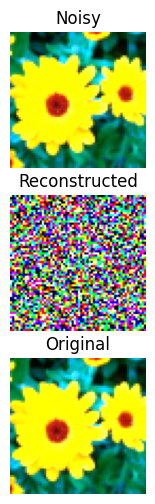

In [59]:
plt.figure(figsize=(2 * NUMBER_OF_IMAGES, 2 * ROWS))
for i in range(NUMBER_OF_IMAGES):
    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 0 * NUMBER_OF_IMAGES + 1)
    plt.imshow(tf.squeeze(noisy_images[i]))
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 1 * NUMBER_OF_IMAGES + 1)
    plt.imshow(tf.squeeze(reconstructed_images[i]))
    plt.title("Reconstructed")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 2 * NUMBER_OF_IMAGES + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis("off")

plt.show()

## Generate random images

In [102]:
def generate_images(model, N=5):
    for i in range(N):
        imgs = forward_diffusion.generate_image(model, img_size)
        imgs = list(reversed(imgs[::(len(imgs) // 5)]))
        plot([tf.squeeze(img) for img in imgs])

1/1 [==============================] - 0s 27ms/step


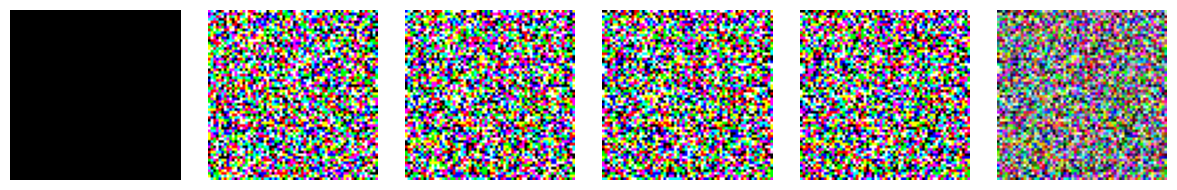

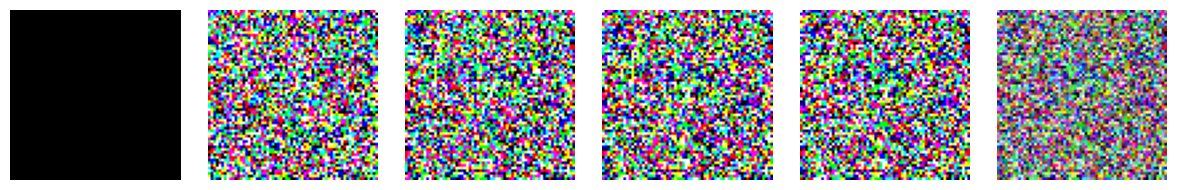

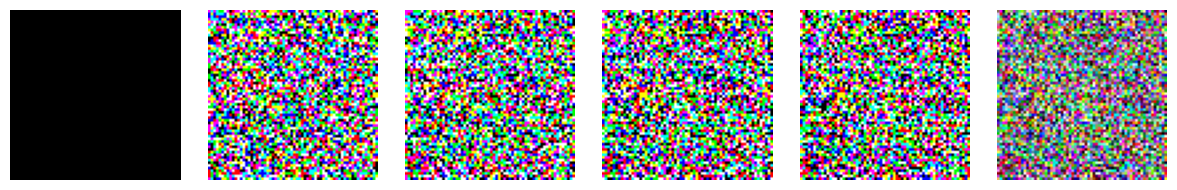

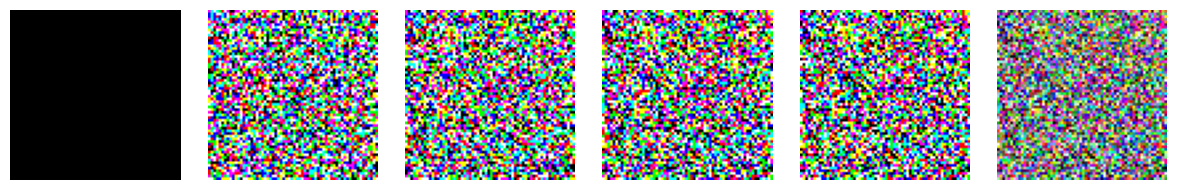

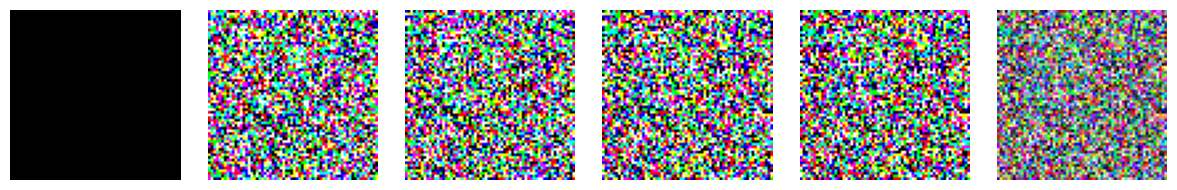

In [108]:
generate_images(model)